### Algorithm: Transformers including normalization vo
### Dataset : Libras
### Author: Edgar Acuna
### Created: April 16, 2025

In [91]:
import tensorflow

In [92]:

import pandas as pd

In [93]:
import pandas as pd
from aeon.datasets import load_classification
from sklearn import preprocessing
from matplotlib import pyplot

def load_data(dataset, split="Train"):
    if split=="Train":
        X, y = load_classification(dataset, split="Train")
    else:
        X, y = load_classification(dataset, split="Test")
    print(" Shape of X = ", X.shape)
    print(" Shape of y = ", y.shape)
    #Swap dimensions so features are the third dimension
    X = X.swapaxes(1, 2)
    print(" New shape of X = ", X.shape)
    #prepare y
    y = pd.DataFrame(y)
    enc = preprocessing.OneHotEncoder(dtype=int)
    enc.fit(y)
    y = enc.transform(y).toarray()
    print(" New shape of y = ", y.shape)
    return X, y


In [94]:
# loading Training data
X, y = load_data("Libras",split="Train")

 Shape of X =  (180, 2, 45)
 Shape of y =  (180,)
 New shape of X =  (180, 45, 2)
 New shape of y =  (180, 15)


In [95]:
import numpy as np
yo=np.argmax(y,axis=1)
yo=np.array(yo,dtype=int)
print(yo)

[ 0  0  0  0  0  0  0  0  0  0  0  0  7  7  7  7  7  7  7  7  7  7  7  7
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
 10 10 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 13 13
 14 14 14 14 14 14 14 14 14 14 14 14  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6]


In [96]:
# loading Testing data
Xt, yt = load_data("Libras",split="Test")

 Shape of X =  (180, 2, 45)
 Shape of y =  (180,)
 New shape of X =  (180, 45, 2)
 New shape of y =  (180, 15)


In [97]:
yto=np.argmax(yt,axis=1)
yto=np.array(yto,dtype=int)
#print(yto)

In [98]:
import numpy as np
Xb= np.concatenate((X, Xt),axis=0)
print(Xb.shape)

(360, 45, 2)


In [99]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#tempo=X.reshape(X.shape[2],-1).T
#print(tempo.shape)
#X = scaler.fit_transform(X.reshape(X.shape[2], -1)).reshape(X.shape)
Xb = scaler.fit_transform(Xb.reshape(Xb.shape[2], -1)).reshape(Xb.shape)
#Xt = scaler.fit_transform(Xt.reshape(Xt.shape[2], -1)).reshape(Xt.shape)
#X1 = scaler.fit_transform(tempo)
#print(X)
#tempodf=pd.DataFrame(X1)
#print(tempodf.shape)
#pyplot.boxplot(tempodf)
#pyplot.show()

In [100]:
Xn1=Xb[0:180]
print(Xn1.shape)
Xn2=Xb[180:360]
print(Xn2.shape)

(180, 45, 2)
(180, 45, 2)


In [101]:
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score, ConfusionMatrixDisplay
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
# Configuration options
#trainX, trainy, testX, testy = trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=42)
trainX=Xn1
trainy=y
testX=Xn2
testy=yt
feature_vector_length = trainX.shape[1]
num_classes = trainy.shape[1]
# Convert target classes to categorical ones
print(trainy.shape)
#trainy= to_categorical(trainy, num_classes)
#testy = to_categorical(testy, num_classes)
print('Train dimension:')
print(trainX.shape)
print('Test dimension:')
print(testX.shape)
#X_train=trainX.to_numpy()
#X_test=testX.to_numpy()
X_train = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2]))
X_test = testX.reshape((testX.shape[0], testX.shape[1], trainX.shape[2]))

(180, 15)
Train dimension:
(180, 45, 2)
Test dimension:
(180, 45, 2)


In [102]:
X_test.shape, testy.shape

((180, 45, 2), (180, 15))

In [103]:
X_train.shape, trainy.shape

((180, 45, 2), (180, 15))

In [104]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [105]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    n_length=45
    n_features=2
    inputs = keras.Input(shape=input_shape)
    x= Conv1D(filters=16, kernel_size=2, activation='relu')(inputs)
    x=MaxPooling1D(pool_size=2)(x)
    #x= Dropout(0.5)(x)
    x= Conv1D(filters=128, kernel_size=2, activation='relu')(x)
    x=MaxPooling1D(pool_size=2)(x)
    #x= Dropout(0.5)(x)
    x= Conv1D(filters=256, kernel_size=2, activation='relu')(x)
    x= MaxPooling1D(pool_size=2)(x)
    #x= Dropout(0.5)(x)
    #x = layers.LayerNormalization(epsilon=1e-6)(x)
    #x=Flatten()(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [106]:
input_shape = X_train.shape[1:]
print('input', input_shape)
import time
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0,
    dropout=0,
)
start_time = time.time()
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

#callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    trainy,
    validation_split=0,
    epochs=200,
    batch_size=8,
    #callbacks=callbacks,
)


input (45, 2)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 45, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 44, 16)    │         80 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 22, 16)    │          0 │ conv1d_33[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 21, 128)   │      4,224 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 10, 128)   │          0 │ conv1d_34[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 9, 256)    │     65,792 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 4, 256)    │          0 │ conv1d_35[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 256)    │        512 │ max_pooling1d_11… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 256)    │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 4, 256)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 4, 256)    │          0 │ dropout_40[0][0], │
│                     │                   │            │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 256)    │        512 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 4, 4)      │      1,028 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 4, 4)      │          0 │ conv1d_36[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 4, 256)    │      1,280 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 4, 256)    │          0 │ conv1d_37[0][0],  │
│                     │                   │            │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 4, 256)    │        512 │ add_25[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 256)    │  1,051,904 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,293,615 (16.38 MB)

 Trainable params: 4,293,615 (16.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.0709 - loss: 2.7126
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0683 - loss: 2.7071
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0978 - loss: 2.7061
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0787 - loss: 2.7017
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0743 - loss: 2.7021
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0726 - loss: 2.7031
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1072 - loss: 2.6894
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0703 - loss: 2.6973
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0829 - loss: 2.6782
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0690 - loss: 2.6889
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0686 - loss: 2.6791
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

In [107]:
results=model.evaluate(X_test, testy, verbose=1)
print("Training time --- %s seconds ---" % (time.time() - start_time))
print(results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1442 - loss: 11.9245
Training time --- 223.77391147613525 seconds ---
[10.612894058227539, 0.13333334028720856]


In [108]:
#Computing F1-score
import numpy as np
import sklearn
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, roc_auc_score
train_features = np.array(X_train)
test_features = np.array(X_test)
train_labels=np.array(trainy)
#train_labels=pd.DataFrame(trainy)
#n_values = train_labels.idxmax(axis=1)
y_values=np.argmax(train_labels,axis=1)
#print(y_values)
test_labels=np.array(testy)
yt_values=np.argmax(test_labels,axis=1)
#train_predictions_baseline = model.predict_classes(train_features, batch_size=150)
a=model.predict([test_features])
predict_classes=np.argmax(a,axis=1)
th=.8
atempo=a.max(axis=1)
print(atempo.shape)
print('Rate of Probability of classification exceeding a threshold in test',(atempo[atempo>th].shape[0])/atempo.shape[0])
#prob2=pd.DataFrame(model.predict_proba(test_features,batch_size=150))
#a=prob2.max(axis=1)
#print('Probability of classification',(a[a>.80].shape[0])/prob2.shape[0])
#print('Rate of Probability of classification exceding a trhershold',(a[a>.50].shape[0])/a.shape[0])
a1=model.predict([train_features])
predict_classes1=np.argmax(a1,axis=1)
#f1_train=sklearn.metrics.f1_score(ytrain, train_predictions_baseline, average="weighted")
#test_predictions_baseline = model.predict_classes(test_features, batch_size=150)
#print(test_predictions_baseline)
#f1_test=sklearn.metrics.f1_score(test_labels, test_predictions_baseline, average="weighted")
#print('f1_scores in testing set',f1_test)
#Calculating metrics for each class
print("EVALUATION ON TESTING DATA")
print(classification_report(yt_values, predict_classes))

C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_141
Received: inputs=('Tensor(shape=(32, 45, 2))',)



1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step

C:\Users\User\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_141
Received: inputs=('Tensor(shape=(None, 45, 2))',)



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
(180,)
Rate of Probability of classification exceeding a threshold in test 0.4666666666666667
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.11      0.17      0.13        12
           1       0.00      0.00      0.00        12
           2       0.17      0.08      0.11        12
           3       0.21      0.25      0.23        12
           4       0.07      0.08      0.08        12
           5       0.07      0.08      0.08        12
           6       0.08      0.08      0.08        12
           7       0.19      0.25      0.21        12
           8       0.50      0.08      0.14        12
           9       0.00      0.00      0.00        12
          10       0.17      0.08      0.11        12
          11       0.33      0.42      0.37        12
          12       0.00      0.00      0.00        12
          13       0.13      0.42      0.20  

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [109]:
cm=confusion_matrix(yt_values, predict_classes)
print(cm)
good=np.diag(cm)/np.unique(yt_values,return_counts=True)[1]
print(good)

[[2 0 0 0 3 1 3 0 0 0 0 1 1 1 0]
 [2 0 0 2 0 0 0 0 0 1 2 2 2 1 0]
 [2 1 1 1 1 0 0 1 0 0 0 0 1 4 0]
 [1 0 1 3 1 1 0 0 1 0 0 1 2 1 0]
 [3 0 0 1 1 0 0 4 0 0 0 1 1 1 0]
 [1 1 0 1 1 1 2 1 0 1 0 1 1 1 0]
 [0 0 0 0 1 5 1 1 0 0 0 0 0 4 0]
 [4 0 0 0 2 1 1 3 0 0 0 0 0 1 0]
 [1 0 0 2 0 3 0 1 1 0 0 2 0 2 0]
 [1 1 0 0 1 0 1 1 0 0 1 2 2 2 0]
 [1 0 2 1 0 1 2 3 0 0 1 0 0 1 0]
 [0 0 0 2 1 0 0 0 0 0 1 5 1 2 0]
 [0 2 0 1 1 1 0 1 0 1 0 0 0 5 0]
 [0 2 1 0 0 0 2 0 0 0 1 0 1 5 0]
 [0 1 1 0 1 0 0 0 0 1 0 0 1 7 0]]
[0.16666667 0.         0.08333333 0.25       0.08333333 0.08333333
 0.08333333 0.25       0.08333333 0.         0.08333333 0.41666667
 0.         0.41666667 0.        ]


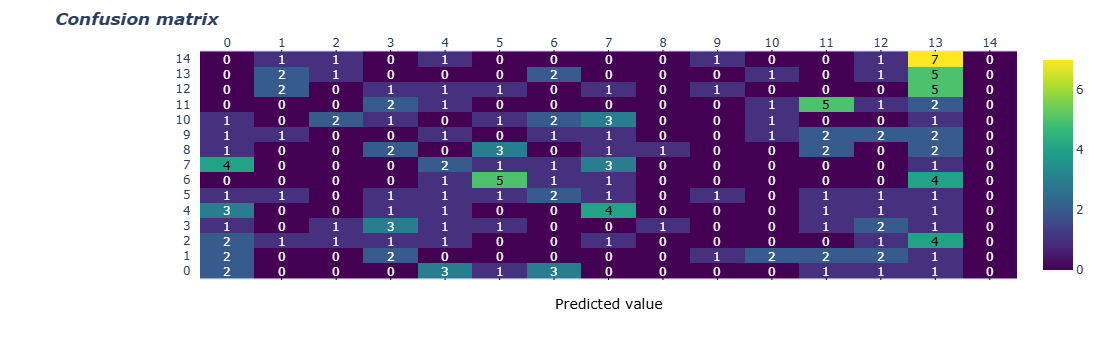

In [110]:
import plotly.figure_factory as ff
# invert z idx values

z= cm

# invert z idx values
#z = z[::-1]

x= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
y1=x
#y =x[::-1].copy() # invert idx values of x
#print(y)
#y=x
# change each element of z to type string for annotations
z_text = [[str(y1) for y1 in x] for x in z]

# set up figure
fig = ff.create_annotated_heatmap(z, x=x, y=y1, annotation_text=z_text, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Actual value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()